# Deepfake Detection
## Author: Sarosh Hassan

### Install dependencies and download dataset

In [1]:
!pip install tensorflow keras-tuner scikit-learn scikit-image opencv-python matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, classification_report
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

Download into dataset folder and unzip to data folder

In [3]:
!mkdir -p dataset
!wget -O dataset/deepfake_dataset.zip "https://data.mendeley.com/public-files/datasets/pdcp9mjy3z/files/450e6387-a3d4-4ba5-8c43-315a081debb9/file_downloaded"
!unzip -q dataset/deepfake_dataset.zip -d /content/data/

--2025-10-23 09:27:18--  https://data.mendeley.com/public-files/datasets/pdcp9mjy3z/files/450e6387-a3d4-4ba5-8c43-315a081debb9/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/de9f62d6-16d6-4a88-905e-21c2ea39e61b [following]
--2025-10-23 09:27:19--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/de9f62d6-16d6-4a88-905e-21c2ea39e61b
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.90.184, 52.218.26.56, 52.92.32.50, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.90.184|:44

## EDA


In [4]:
FAKE_DIR="/content/data/deepfake_dataset/deepfake"
REAL_DIR="/content/data/deepfake_dataset/real"

In [5]:
# Function to read n images from directory
def load_images_from_folder(folder, n=6, size=(128,128)):
    images = []
    for filename in sorted(os.listdir(folder))[:n]:
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(cv2.resize(img, size), cv2.COLOR_BGR2RGB)
            images.append(img)
    return images

# Load 5 real and 5 fake
real_imgs = load_images_from_folder(REAL_DIR, 6)
fake_imgs = load_images_from_folder(FAKE_DIR, 6)


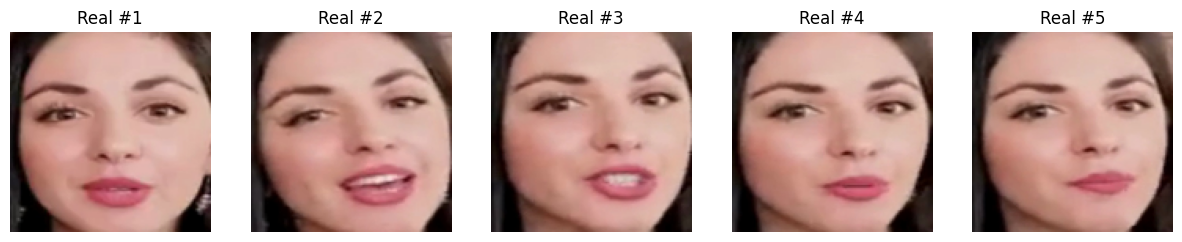

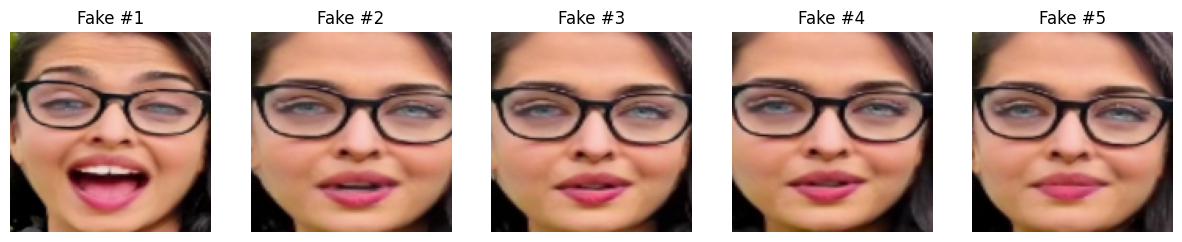

In [6]:
def show_images(images, title):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} #{i+1}")
    plt.show()

show_images(real_imgs, "Real")
show_images(fake_imgs, "Fake")

### Features Visualization and Analysis

Color Histogram

 Real Images - Color Histogram


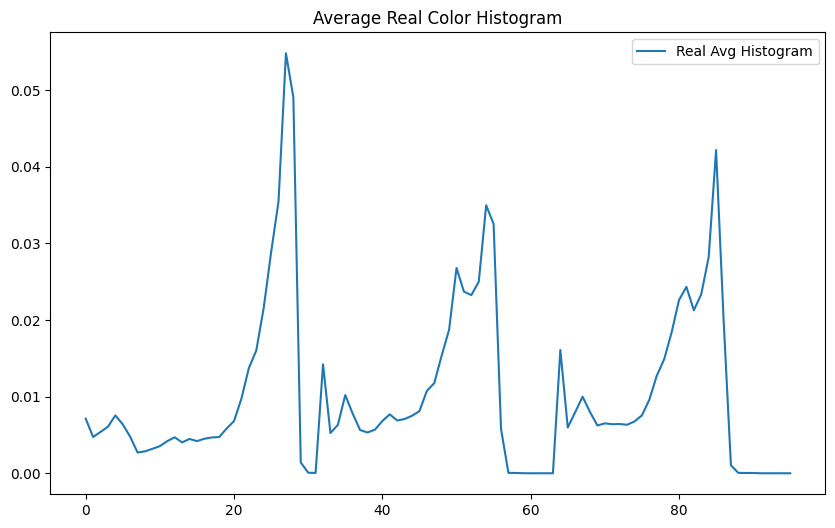

Real Image #1 - Similarity to Avg: 0.9924
Real Image #2 - Similarity to Avg: 0.9965
Real Image #3 - Similarity to Avg: 0.9981
Real Image #4 - Similarity to Avg: 0.9984
Real Image #5 - Similarity to Avg: 0.9968


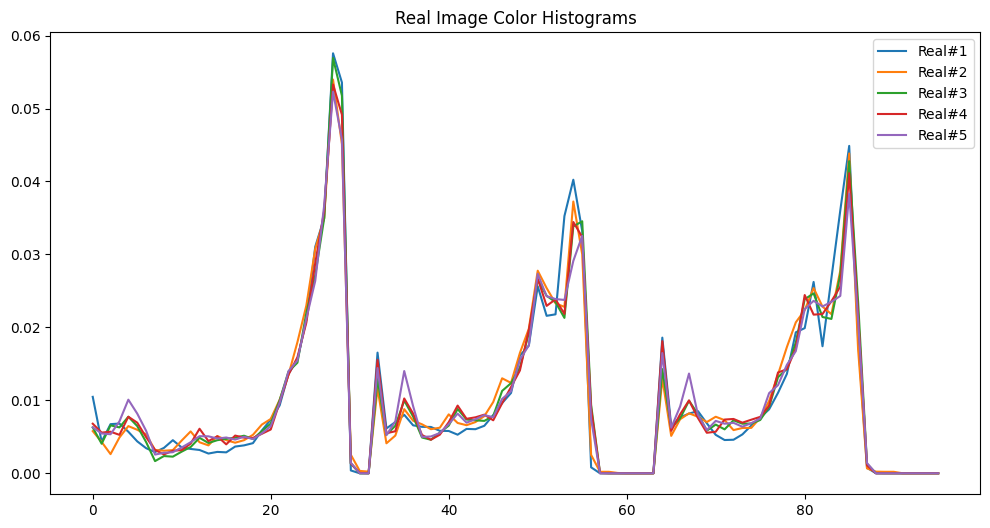


yy Fake Images - Color Histogram


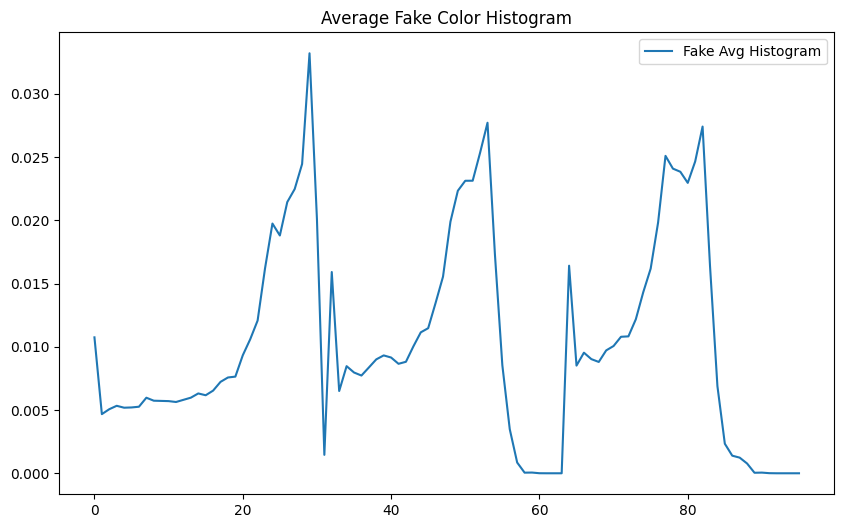

Fake Image #1 - Similarity to Avg: 0.9839
Fake Image #2 - Similarity to Avg: 0.9951
Fake Image #3 - Similarity to Avg: 0.9979
Fake Image #4 - Similarity to Avg: 0.9970
Fake Image #5 - Similarity to Avg: 0.9975


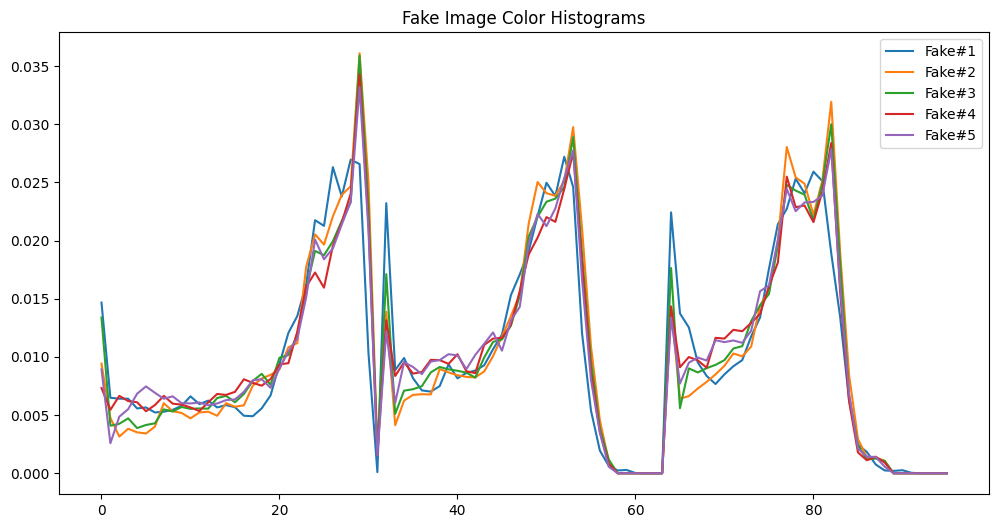

In [7]:
from skimage.feature import local_binary_pattern
from sklearn.metrics.pairwise import cosine_similarity

def color_histogram(img):
    hist = []
    for i in range(3):  # RGB channels
        h = cv2.calcHist([img], [i], None, [32], [0, 256])
        hist.extend(h.flatten())
    hist = np.array(hist)
    hist /= np.sum(hist)
    return hist

def compare_histograms(images, label):
    hists = [color_histogram(img) for img in images]
    avg_hist = np.mean(hists, axis=0)
    plt.figure(figsize=(10,6))
    plt.plot(avg_hist, label=f"{label} Avg Histogram")
    plt.title(f"Average {label} Color Histogram")
    plt.legend()
    plt.show()

    for i, h in enumerate(hists):
        sim = cosine_similarity(avg_hist.reshape(1,-1), h.reshape(1,-1))[0][0]
        print(f"{label} Image #{i+1} - Similarity to Avg: {sim:.4f}")

    # Plot each histogram
    plt.figure(figsize=(12,6))
    for i,h in enumerate(hists):
        plt.plot(h, label=f"{label}#{i+1}")
    plt.legend()
    plt.title(f"{label} Image Color Histograms")
    plt.show()

print(" Real Images - Color Histogram")
compare_histograms(real_imgs, "Real")

print("\nyy Fake Images - Color Histogram")
compare_histograms(fake_imgs, "Fake")

LBP


 Real Images - LBP


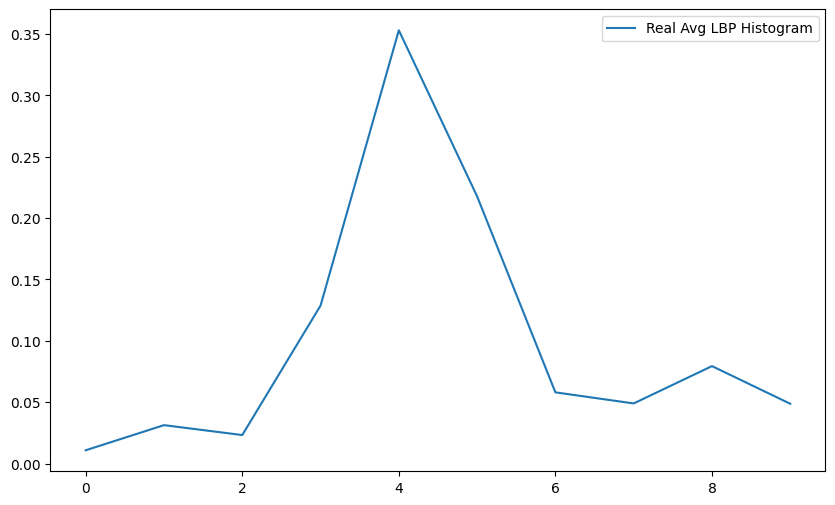

Real Image #1 - LBP similarity to Avg: 0.9974
Real Image #2 - LBP similarity to Avg: 0.9989
Real Image #3 - LBP similarity to Avg: 0.9998
Real Image #4 - LBP similarity to Avg: 0.9997
Real Image #5 - LBP similarity to Avg: 0.9998


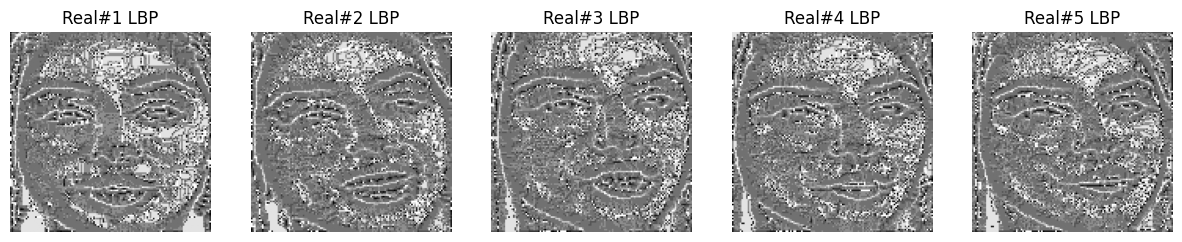


 Fake Images - LBP


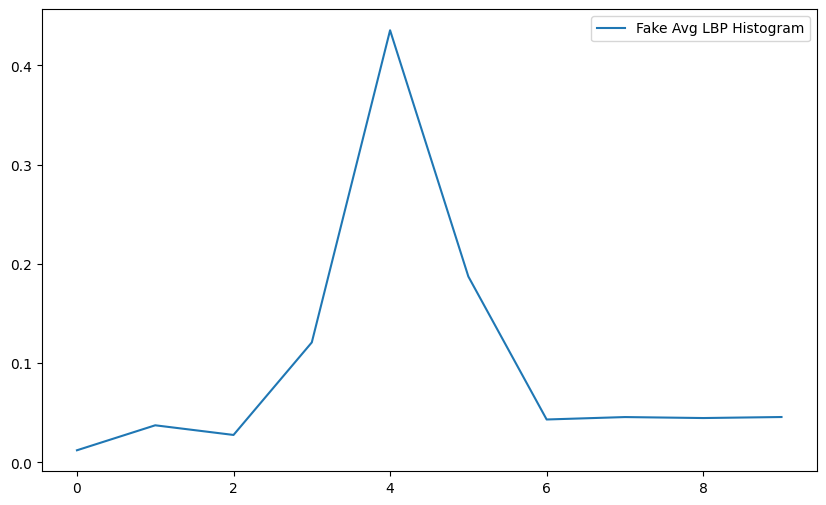

Fake Image #1 - LBP similarity to Avg: 0.9993
Fake Image #2 - LBP similarity to Avg: 0.9997
Fake Image #3 - LBP similarity to Avg: 0.9999
Fake Image #4 - LBP similarity to Avg: 0.9999
Fake Image #5 - LBP similarity to Avg: 0.9999


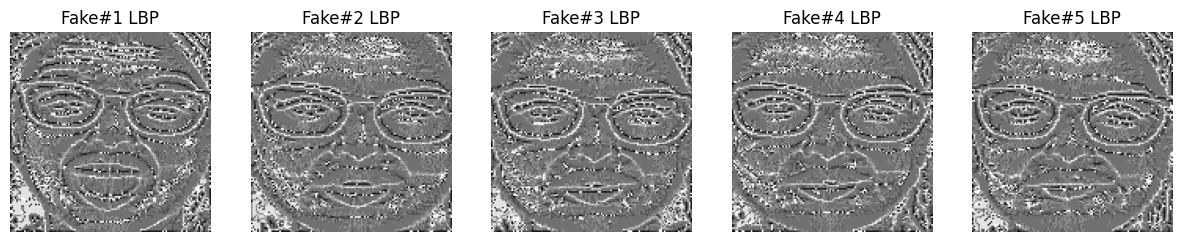

In [8]:
def lbp_feature(img, P=8, R=1):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return lbp, hist

def compare_lbps(images, label):
    lbps, hists = [], []
    for img in images:
        lbp, hist = lbp_feature(img)
        lbps.append(lbp)
        hists.append(hist)

    avg_hist = np.mean(hists, axis=0)

    plt.figure(figsize=(10,6))
    plt.plot(avg_hist, label=f"{label} Avg LBP Histogram")
    plt.legend(); plt.show()

    for i, h in enumerate(hists):
        sim = cosine_similarity(avg_hist.reshape(1,-1), h.reshape(1,-1))[0][0]
        print(f"{label} Image #{i+1} - LBP similarity to Avg: {sim:.4f}")

    # Display LBP images
    plt.figure(figsize=(15,5))
    for i, lbp in enumerate(lbps):
        plt.subplot(1,5,i+1)
        plt.imshow(lbp, cmap='gray')
        plt.axis('off')
        plt.title(f"{label}#{i+1} LBP")
    plt.show()

print("\n Real Images - LBP")
compare_lbps(real_imgs, "Real")

print("\n Fake Images - LBP")
compare_lbps(fake_imgs, "Fake")


Edge Density


 Real Images - Edge Density

Real Avg Edge Density: 0.0644
Real Image #1 - Edge Density similarity: 0.9979
Real Image #2 - Edge Density similarity: 0.9933
Real Image #3 - Edge Density similarity: 0.9996
Real Image #4 - Edge Density similarity: 0.9959
Real Image #5 - Edge Density similarity: 0.9957


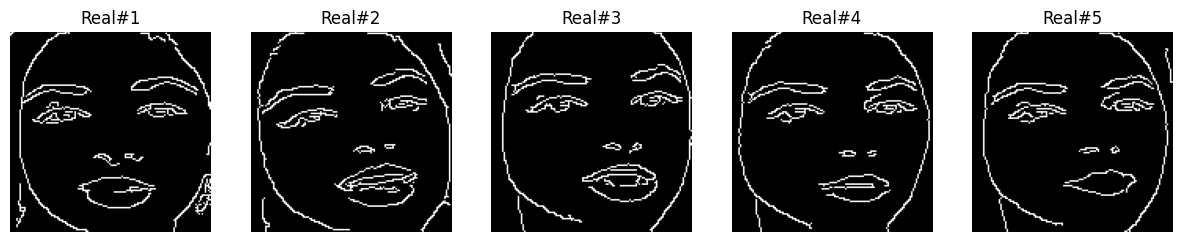


 Fake Images - Edge Density

Fake Avg Edge Density: 0.1131
Fake Image #1 - Edge Density similarity: 0.9773
Fake Image #2 - Edge Density similarity: 0.9858
Fake Image #3 - Edge Density similarity: 0.9966
Fake Image #4 - Edge Density similarity: 0.9985
Fake Image #5 - Edge Density similarity: 0.9964


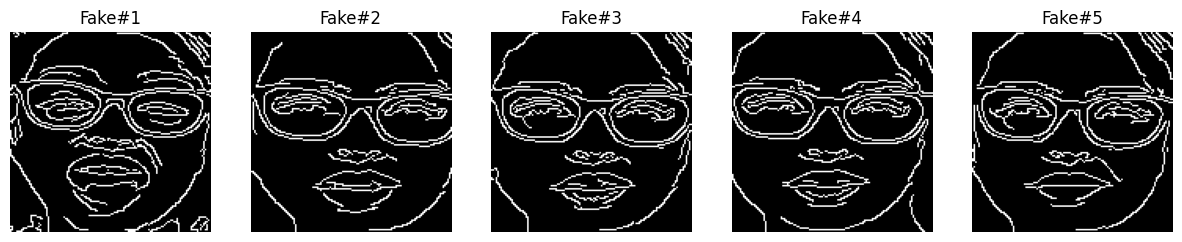

In [9]:
def edge_density(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    density = np.sum(edges > 0) / edges.size
    return edges, density

def compare_edges(images, label):
    edges_list, densities = [], []
    for img in images:
        edges, dens = edge_density(img)
        edges_list.append(edges)
        densities.append(dens)

    avg_density = np.mean(densities)
    print(f"\n{label} Avg Edge Density: {avg_density:.4f}")

    for i, dens in enumerate(densities):
        sim = 1 - abs(avg_density - dens)  # inverse difference
        print(f"{label} Image #{i+1} - Edge Density similarity: {sim:.4f}")

    # Display edges
    plt.figure(figsize=(15,5))
    for i, e in enumerate(edges_list):
        plt.subplot(1,5,i+1)
        plt.imshow(e, cmap='gray')
        plt.axis('off')
        plt.title(f"{label}#{i+1}")
    plt.show()

print("\n Real Images - Edge Density")
compare_edges(real_imgs, "Real")

print("\n Fake Images - Edge Density")
compare_edges(fake_imgs, "Fake")

## Feature Extraction

In [10]:
def load_image(path, img_size=(128,128)):
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, img_size)
  img = img.astype(np.float32) / 255.0
  return img


def extract_color_histogram(img, bins=32):
  hist = []
  for i in range(3):
    h = cv2.calcHist([img.astype('float32')],[i],None,[bins],[0,1]).flatten()
    h = h / (h.sum()+1e-8)
    hist.extend(h.tolist())
  return np.array(hist)


def extract_lbp(img_gray, P=8, R=1):
  lbp = local_binary_pattern(img_gray, P, R, method='uniform')
  n_bins = int(lbp.max() + 1)
  h, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
  h = h / (h.sum()+1e-8)
  return h


def extract_edge_density(img_gray):
  edges = cv2.Canny((img_gray*255).astype('uint8'), 100, 200)
  return np.array([edges.mean()])


def compute_features(img):
  gray = rgb2gray(img)
  return np.concatenate([extract_color_histogram(img), extract_lbp(gray), extract_edge_density(gray)])


def load_dataset(data_dir, limit=1e4, img_size=(128,128)):
  paths, labels = [], []
  for label in ['real', 'deepfake']:
    folder = os.path.join(data_dir, label)
    files = [os.path.join(folder,f) for f in os.listdir(folder) if f.lower().endswith(('jpg','jpeg','png'))]
    for f in files[:limit//2]:
      paths.append(f)
      labels.append(0 if label=='real' else 1)
  return paths, np.array(labels)


ROOT_DIR = '/content/data/deepfake_dataset'
paths, labels = load_dataset(ROOT_DIR, limit=10000)
print('Loaded', len(paths), 'images')

Loaded 8744 images


Feature Assimilation

In [11]:
X = np.empty((len(paths), 128, 128, 3), dtype=np.float32)
features = []
for i, path in enumerate(tqdm(paths)):
  img = load_image(path)
  X[i] = img
  features.append(compute_features(img))
features = np.vstack(features)
print('Feature shape:', features.shape)

  0%|          | 0/8744 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 8744/8744 [01:07<00:00, 129.47it/s]

Feature shape: (8744, 107)


In [12]:
print("Labels shape:", labels.shape)

Labels shape: (8744,)


#### Stratified Split

In [13]:
sss = StratifiedShuffleSplit(n_splits=10, train_size=0.8 ,test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, labels):
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = labels[train_idx], labels[test_idx]
  feats_train, feats_test = features[train_idx], features[test_idx]

## Model Architecture and Hyperparameter Tuning

In [14]:
def build_model(hp):
  inputs = keras.Input(shape=(128,128,3))
  x = inputs
  for i in range(hp.Int('conv_blocks', 2, 4, default=3)):
    x = layers.Conv2D(hp.Choice(f'filters_{i}', [16,32,64,128], default=32), (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1, default=0.3))(x)
  x = layers.Flatten()(x)
  x = layers.Dense(hp.Int('dense_units', 64, 256, step=64, default=128), activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.3)(x)
  output = layers.Dense(1, activation='sigmoid')(x)
  model = keras.Model(inputs, output)


  opt = keras.optimizers.Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log'))
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='recall')])
  return model

In [15]:
def build_model_2(hp):
    inputs = keras.Input(shape=(128, 128, 3))
    x = inputs

    # --- Convolutional Blocks ---
    for i in range(hp.Int('conv_blocks', 2, 4, default=3)):
        # Let tuner choose number of filters and kernel size
        filters = hp.Choice(f'filters_{i}', [16, 32, 64, 128], default=32)
        kernel_size = hp.Choice(f'kernel_size_{i}', [3, 5, 7], default=3)

        # Convolution layer
        x = layers.Conv2D(
            filters=filters,
            kernel_size=(kernel_size, kernel_size),
            padding='same',
            activation='relu'
        )(x)

        # Pooling + Normalization + Dropout
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(
            hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1, default=0.1)
        )(x)

    # --- Fully Connected Head ---
    x = layers.Flatten()(x)
    x = layers.Dense(
        hp.Int('dense_units', 64, 256, step=64, default=128),
        activation='relu'
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # --- Output Layer ---
    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, output)

    # --- Optimizer and Compilation ---
    opt = keras.optimizers.Adam(
        learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
    )
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.Recall(name='recall')]
    )
    return model


In [16]:
#dummy hyperparams for visualizing model layers
from keras_tuner import HyperParameters
hp = HyperParameters()


In [17]:
#visualizing model 1 layers
model_1 = build_model(hp)
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,121 (4.08 MB)

 Trainable params: 1,068,673 (4.08 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
#visualizing model 2 layers
model_2 = build_model_2(hp)
model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,121 (4.08 MB)

 Trainable params: 1,068,673 (4.08 MB)

 Non-trainable params: 448 (1.75 KB)

## Analysis of model performance

### Model 1

In [19]:
tuner_model1 = kt.RandomSearch(
build_model,
objective='val_recall',
max_trials=5,
directory='tuner',
project_name='deepfake_cnn_simple'
)

stop_recall = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=5, restore_best_weights=True)



### Model 2

In [20]:
tuner_model2 = kt.RandomSearch(
build_model_2,
objective='val_recall',
max_trials=5,
directory='tuner',
project_name='deepfake_cnn_resnet'
)

stop_recall = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=5, restore_best_weights=True)



In [21]:
tuner_model1.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_recall])
tuner_model2.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_recall])


Trial 5 Complete [00h 01m 06s]
val_recall: 0.8431122303009033

Best val_recall So Far: 0.9795918464660645
Total elapsed time: 00h 08m 16s


In [22]:
best_model1 = tuner_model1.get_best_models(num_models=1)[0]
best_model2 = tuner_model2.get_best_models(num_models=1)[0]

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
best_models = [
    {'name': 'Custom_CNN', 'model': best_model1},
    {'name': 'ResNet_CNN', 'model': best_model2}
]

### Saving best performing model

In [24]:
class RecallStopping(tf.keras.callbacks.Callback):
  def __init__(self, threshold=0.98):
    super().__init__()
    self.threshold = threshold
  def on_epoch_end(self, epoch, logs=None):
    recall = logs.get('val_recall')
    if recall and recall >= self.threshold:
      print(f"\nRecall reached {recall:.2f} > {self.threshold*100:.2f}%. Stopping.")
      self.model.stop_training = True

early_recall = RecallStopping(threshold=0.98)


In [25]:
history_1 = best_model1.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_recall])

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 44s 185ms/step - accuracy: 0.6237 - loss: 0.6960 - recall: 0.6983 - val_accuracy: 0.4475 - val_loss: 0.7428 - val_recall: 0.0166
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.6795 - loss: 0.6162 - recall: 0.7449 - val_accuracy: 0.6033 - val_loss: 0.6649 - val_recall: 0.9145
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7207 - loss: 0.5493 - recall: 0.7779 - val_accuracy: 0.6297 - val_loss: 0.6378 - val_recall: 0.6390
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7513 - loss: 0.5039 - recall: 0.8094 - val_accuracy: 0.6333 - val_loss: 0.7608 - val_recall: 0.9515
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.7743 - loss: 0.4743 - recall: 0.8288 - val_accuracy: 0.6984 - val_loss: 0.5919 - val_recall: 0.8763
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.8088 - loss: 0.4123 - recall: 0.8435 - val_accuracy: 0.7062 - val_loss: 0.6419 - val_recall

In [26]:
history_2 = best_model2.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_recall])

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 63ms/step - accuracy: 0.7377 - loss: 0.5284 - recall: 0.8019 - val_accuracy: 0.7205 - val_loss: 0.5166 - val_recall: 0.9490
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7931 - loss: 0.4508 - recall: 0.8606 - val_accuracy: 0.7627 - val_loss: 0.4982 - val_recall: 0.6224
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8311 - loss: 0.3803 - recall: 0.8631 - val_accuracy: 0.8006 - val_loss: 0.4211 - val_recall: 0.8801
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8518 - loss: 0.3467 - recall: 0.8784 - val_accuracy: 0.6455 - val_loss: 1.0604 - val_recall: 0.4286
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8400 - loss: 0.3585 - recall: 0.8759 - val_accuracy: 0.8120 - val_loss: 0.4999 - val_recall: 0.7296
Epoch 6/20
172/175 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8654 - loss: 0.3119 - recall: 0.8780
Recall reached 0.98 > 98.00%. Stopping.
175/175 ━━━━━━━━━━━━

## Model Evaluation and Training Plot visualization

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
Accuracy: 90.22% | Recall: 94.20% | F1-score: 91.68%


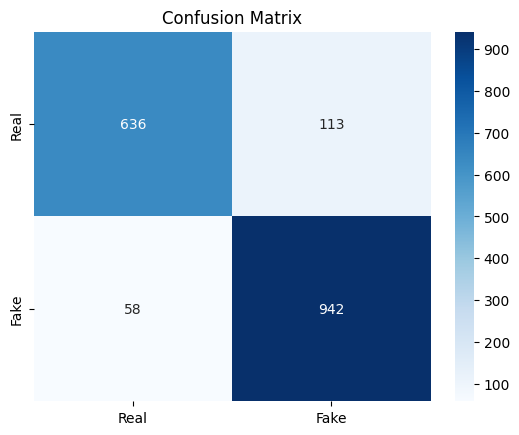

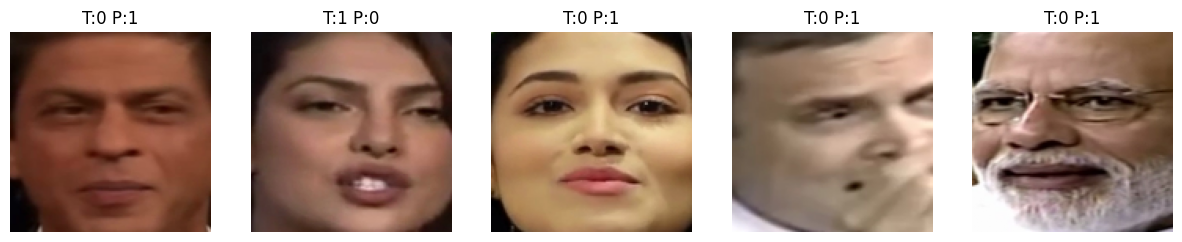

In [27]:
y_pred = (best_model1.predict(X_test).ravel() > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {acc*100:.2f}% | Recall: {rec*100:.2f}% | F1-score: {f1*100:.2f}%")


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.title('Confusion Matrix')
plt.show()


# Display 5 misclassified
mis_idx = np.where(y_test != y_pred)[0][:5]
plt.figure(figsize=(15,5))
for i, idx in enumerate(mis_idx):
  plt.subplot(1,5,i+1)
  plt.imshow(X_test[idx])
  plt.title(f'T:{y_test[idx]} P:{y_pred[idx]}')
  plt.axis('off')
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Accuracy: 74.79% | Recall: 97.70% | F1-score: 81.59%


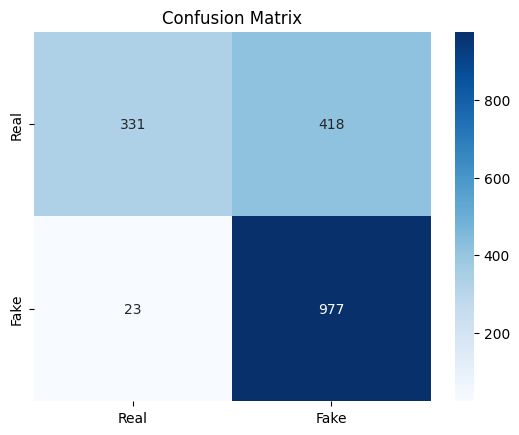

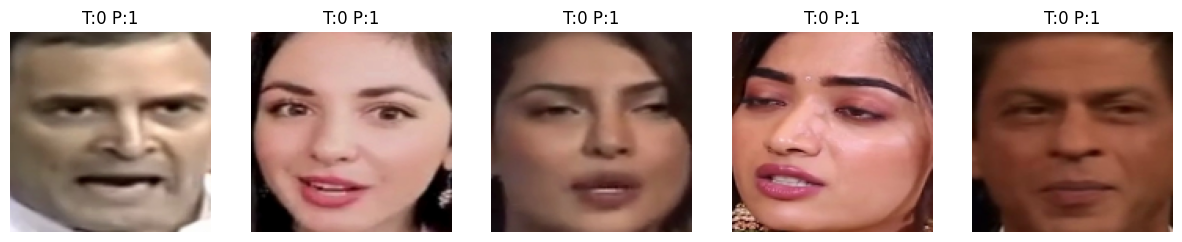

In [28]:
y_pred = (best_model2.predict(X_test).ravel() > 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print(f"Accuracy: {acc*100:.2f}% | Recall: {rec*100:.2f}% | F1-score: {f1*100:.2f}%")


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.title('Confusion Matrix')
plt.show()


# Display 5 misclassified
mis_idx = np.where(y_test != y_pred)[0][:5]
plt.figure(figsize=(15,5))
for i, idx in enumerate(mis_idx):
  plt.subplot(1,5,i+1)
  plt.imshow(X_test[idx])
  plt.title(f'T:{y_test[idx]} P:{y_pred[idx]}')
  plt.axis('off')
plt.show()

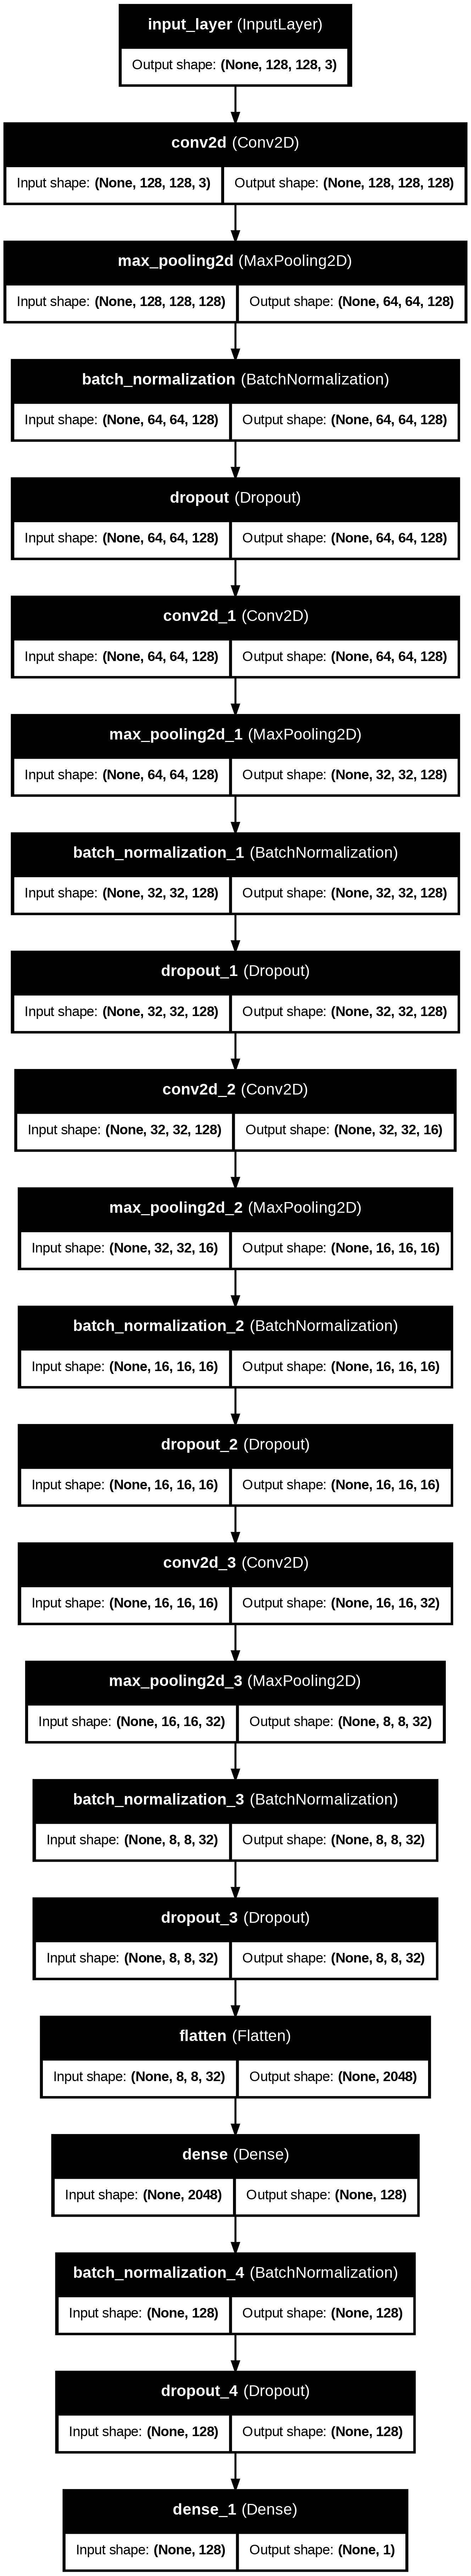

In [30]:
from tensorflow.keras.utils import plot_model

plot_model(
    best_model1,
    to_file="/content/model_structure.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)


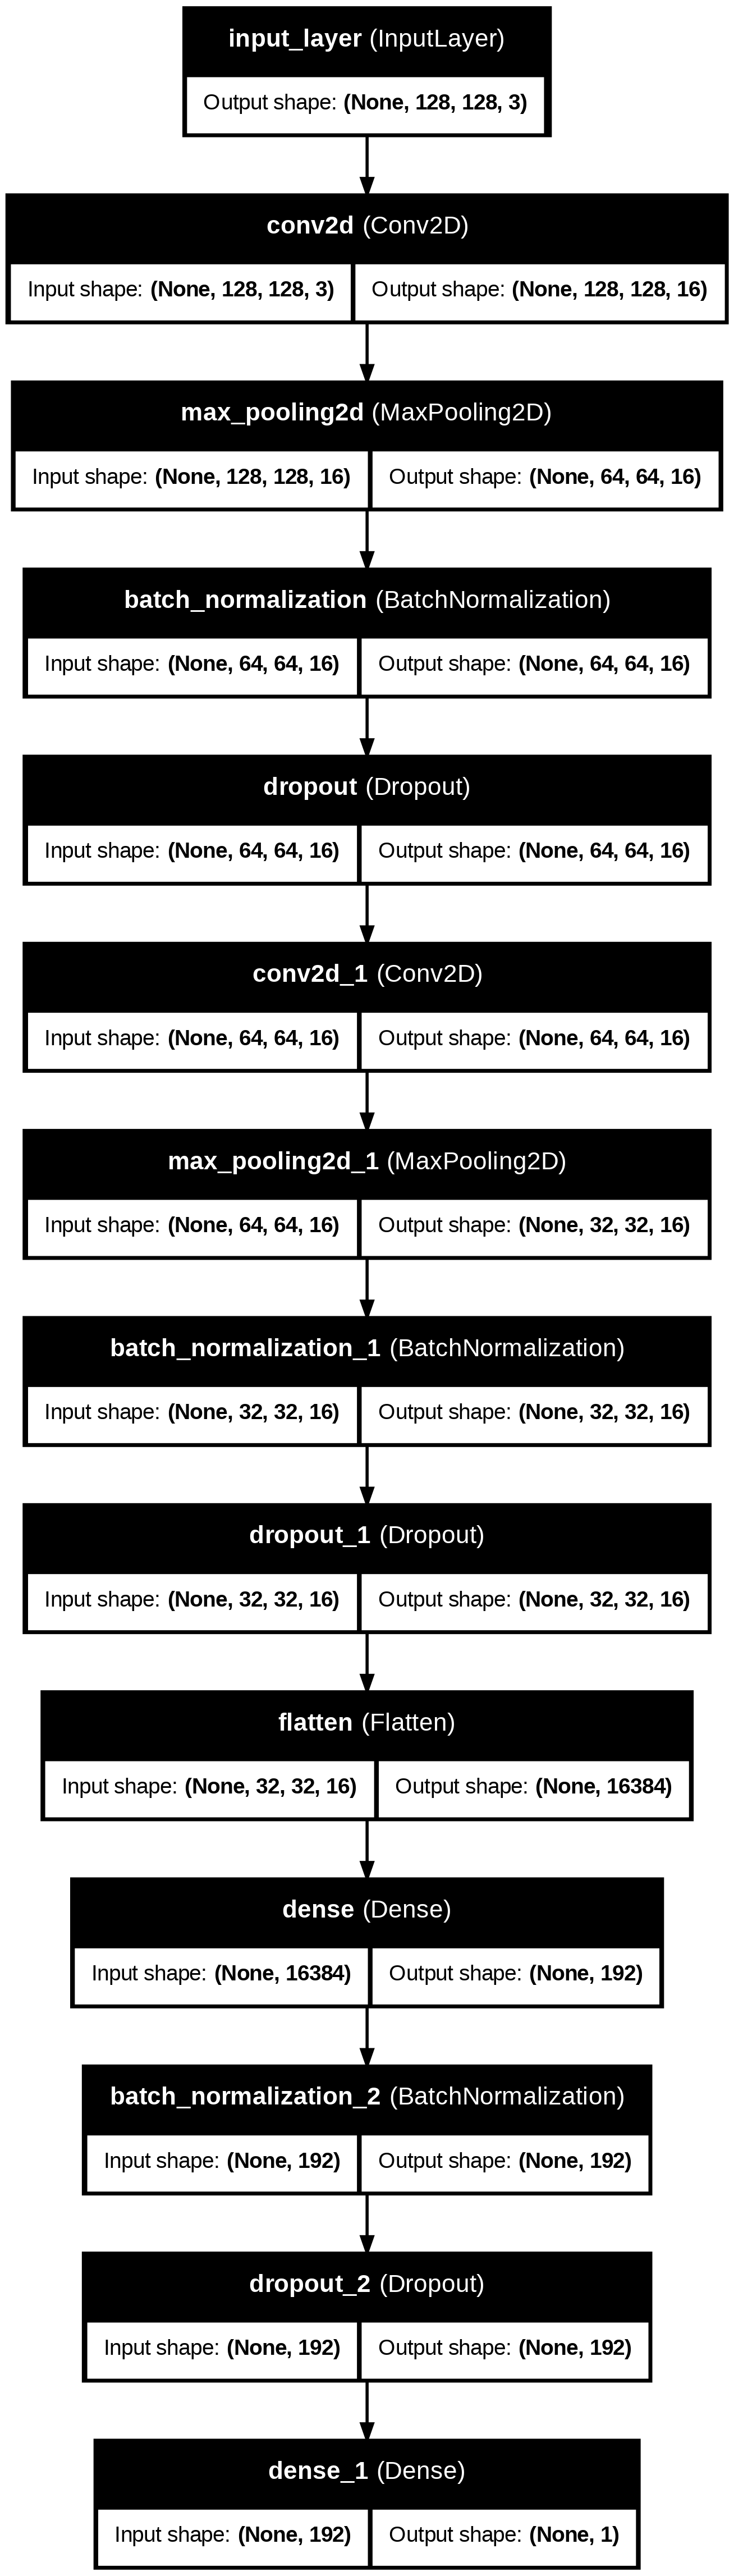

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(
    best_model2,
    to_file="/content/model_structure.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True
)


In [32]:
for entry in best_models:
    name = entry['name']
    model = entry['model']
    print(f"\n🔍 Evaluating {name}...")
    y_pred = (model.predict(X_test).ravel() > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f}")



🔍 Evaluating Custom_CNN...
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Accuracy: 0.9022 | Recall: 0.9420 | F1-Score: 0.9168

🔍 Evaluating ResNet_CNN...
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.7479 | Recall: 0.9770 | F1-Score: 0.8159


### Train Metrics

#### Model 1

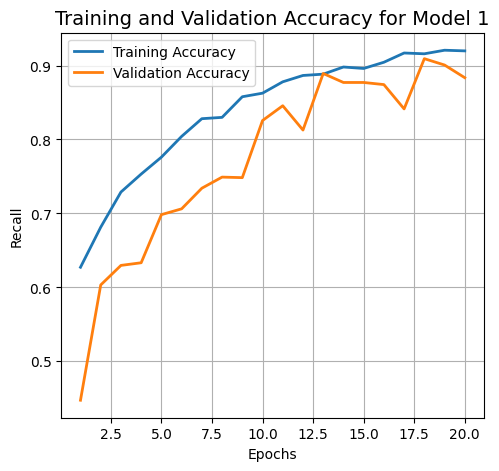

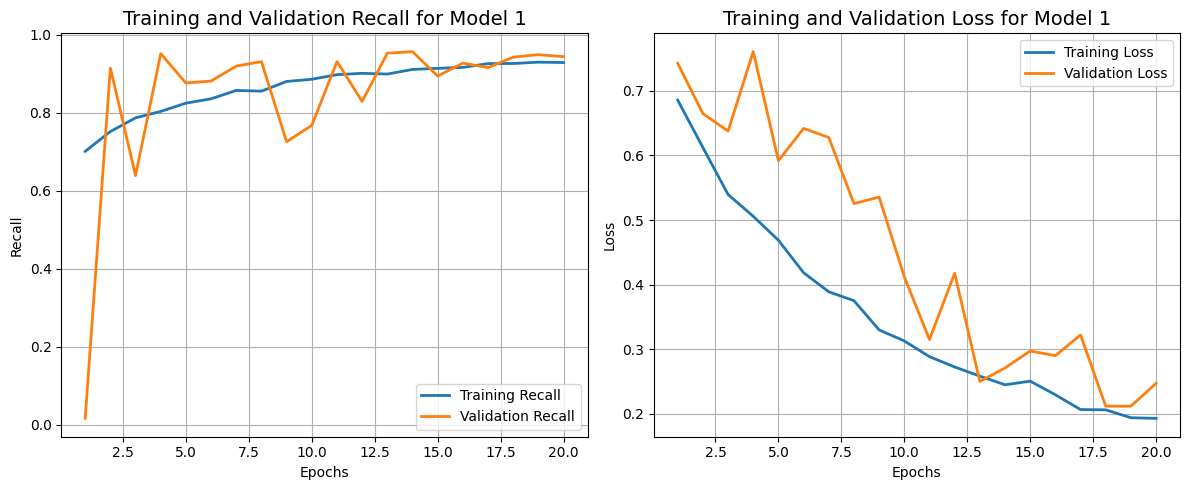

In [36]:
import matplotlib.pyplot as plt

# Extract training history for model 1
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
recall = history_1.history['recall']
val_recall = history_1.history['val_recall']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# --- Plot Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy for Model 1', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# --- Plot Recall ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, recall, label='Training Recall', linewidth=2)
plt.plot(epochs_range, val_recall, label='Validation Recall', linewidth=2)
plt.title('Training and Validation Recall for Model 1', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss for Model 1', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### Model 2

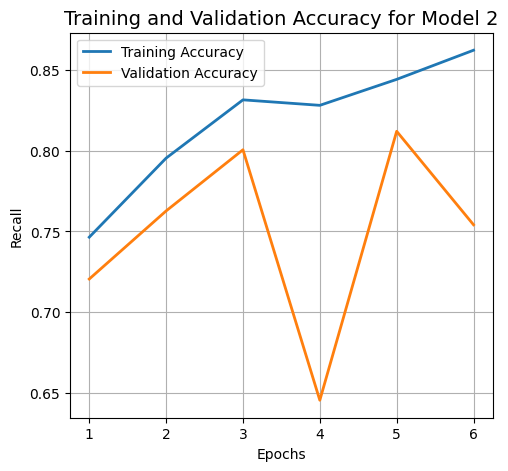

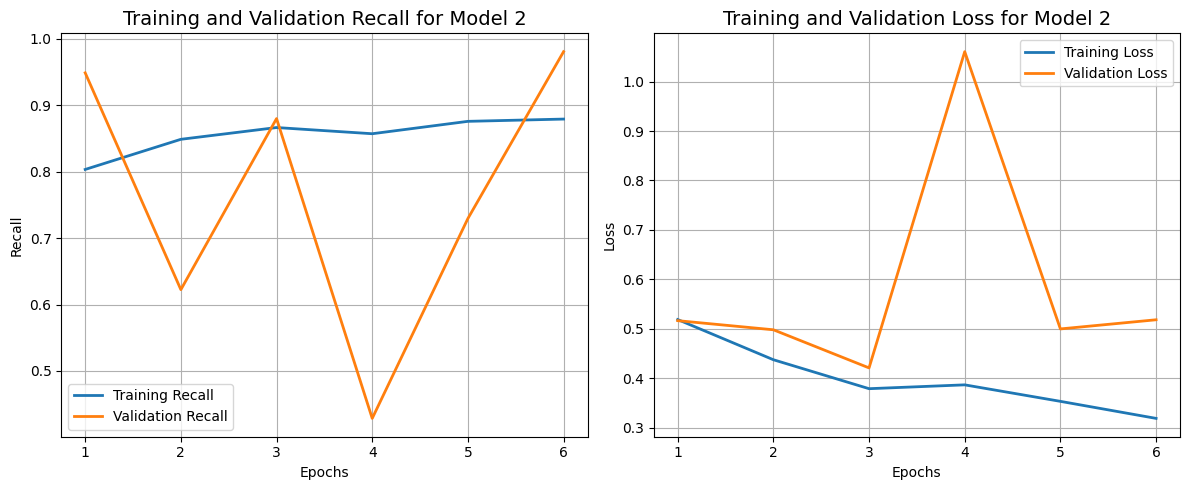

In [38]:
import matplotlib.pyplot as plt

# Extract training history for model 1
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
recall = history_2.history['recall']
val_recall = history_2.history['val_recall']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# --- Plot Accuracy ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy for Model 2', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# --- Plot Recall ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, recall, label='Training Recall', linewidth=2)
plt.plot(epochs_range, val_recall, label='Validation Recall', linewidth=2)
plt.title('Training and Validation Recall for Model 2', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss for Model 2', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
